# CV

## 流程

1. 获取数据，将数据转化为tensor
2. 建立模型
    - 选一个loss函数、优化器
    - 选择视觉模型、训练模型
3. 预测模型
4. 评估模型
5. 提升模型
    - 加loop次数、增net层数、增加hint的神经数
    - 使用non-linear层
    - 修改学习率、损失函数、优化器
6. 保存模型

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.13.1
torchvision version: 0.14.1


In [26]:
# 获取训练数据、测试数据

train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

type(train_data.data), train_data.__dict__

(torch.Tensor,
 {'root': 'data',
  'transform': ToTensor(),
  'target_transform': None,
  'transforms': StandardTransform
  Transform: ToTensor(),
  'train': True,
  'data': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          ...,
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
          

In [21]:
# 
image, label = train_data[5999]

image[0][1]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2510, 0.6784,
        0.8118, 0.8549, 0.8078, 0.9098, 0.7216, 0.6588, 0.7922, 0.8039, 0.8549,
        0.7922, 0.4941, 0.0471, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0000,
        0.0000])

In [14]:
# [color_channels=1, height=28, width=28], 'CWH'

image.shape, label

(torch.Size([1, 28, 28]), 9)

In [26]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Text(0.5, 1.0, '9')

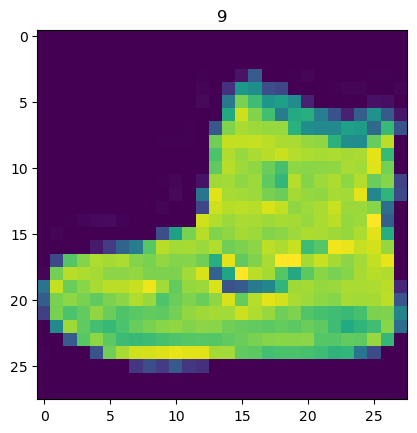

In [51]:
import matplotlib.pyplot as plt
image, label = train_data[0]
plt.imshow(image.squeeze())
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

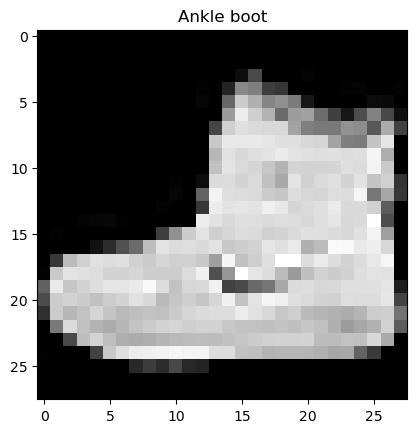

In [28]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

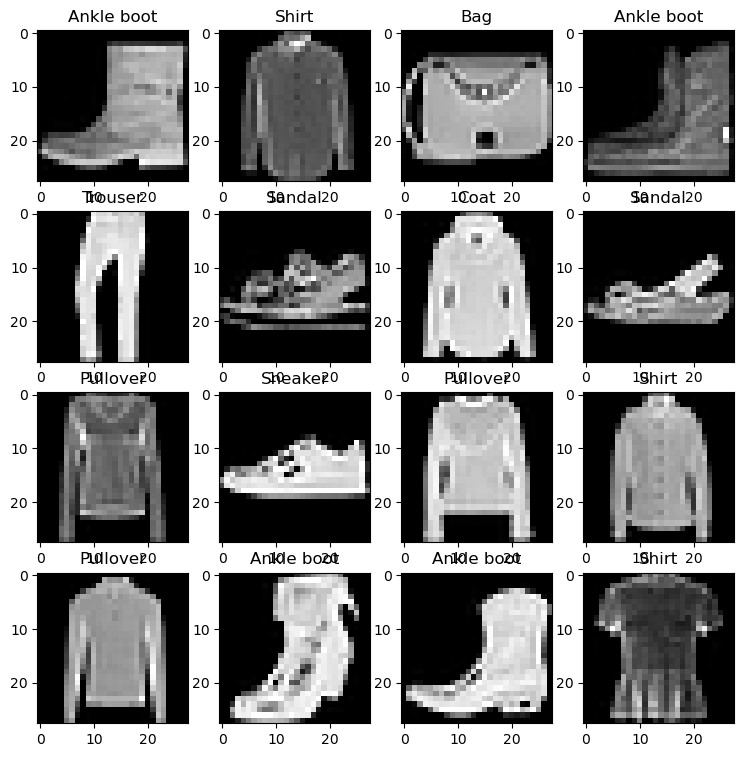

In [40]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(True)

#### 1.2 准备数据加载器

这一步是为了让训练模型按批次加载我们上述准备好的数据，按照batch_size，这也是非常有效的计算

In [61]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, 
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)
##### 看看train_dataloader里面有什么东西
train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(test_dataloader))
train_features_batch.shape, train_labels_batch.shape, test_features_batch.shape, test_labels_batch.shape

(torch.Size([32, 1, 28, 28]),
 torch.Size([32]),
 torch.Size([32, 1, 28, 28]),
 torch.Size([32]))

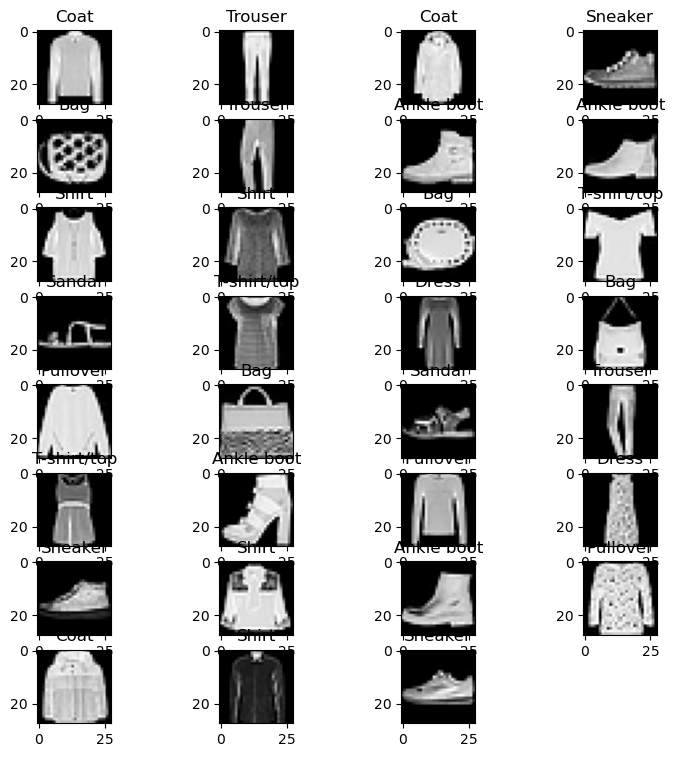

In [62]:
torch.manual_seed(42)
fig = plt.figure(figsize = (9, 9))
# random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
# img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
for i in range(1, len(train_features_batch)):
    random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
    img, label = train_features_batch[i], train_labels_batch[i]
    fig.add_subplot(8, 4, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])

####  3. 建立基线模型

In [96]:
##### nn.Flatten() 让 [1, 28, 28] 变成为 [1, 784]

flatten_model = nn.Flatten()
x = train_features_batch[0]

output = flatten_model(x)

x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [79]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_shape: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_shape),
            nn.Linear(in_features=hidden_shape, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [81]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape=784, hidden_shape=10, output_shape=len(class_names))

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [82]:
import requests
from pathlib import Path


if Path("helper_functions.py").is_file():
    print("helper_function.py is already prepared")
else:
    print("Downloading helper_function.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_function.py", "wb") as f:
        f.write(request.content)

In [83]:
from helper_function import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

loss_fn, optimizer

(CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.1
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [84]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [92]:
##### 对模型进行训练

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

print(iter(train_dataloader))

In [85]:
##### 对模型进行训练

# 显示进度条
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train() 
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on cpu: 23.240 seconds


#### 4. 做预测和评估

In [86]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    # 使用torch.inference_mode()来进行预测
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4766390025615692,
 'model_acc': 83.42651757188499}

In [97]:
torch.cuda.device_count()

0